I know almost nothing about sports, so maybe that's why I'm fascinated by the insights that can be gleaned from careful analysis of sports data. What makes a good player or a good team? What are the strategies used? Aside from obvious strength disparities, what are the differences between men and women's sports? For this project, I looked at tennis data. Tennis Abstract has data on the last 52 games played for the top 50 men and women tennis players. <br>

Men's :http://www.tennisabstract.com/cgi-bin/leaders.cgi <br>
Women's: http://www.tennisabstract.com/cgi-bin/leaders_wta.cgi. <br>

I converted this data to csv files and imported them into this notebook. I wanted to see if there are different "types" of tennis players and how these types correlate with gender. As such, it was an unsupervised learning task. The data set is fairly small (100 players), and the data consists entirely of outcome metrics (e.g. service points won) rather than data about physical aspects of gameplay (e.g. serve speed), so I may not have the resolution needed to exhaustively answer this question.

I started by looking at the distributions of the metrics in both datasets. I removed features that were explicitly associated with rank because I wanted to consider player categories while blind to rank. I also removed some redundant features and features for which some players did not have enough data.

In [51]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

#import csv files
mt_df = pd.read_csv('tennisdata_mens.csv')
wt_df = pd.read_csv('tennisdata_womens.csv')
wt_df = wt_df.drop(50)

#add gender column
wt_df['Gender'] = 0
mt_df['Gender'] = 1

#convert times to datetime objects
t2 = dt.datetime(1900,1,1)
mt_df['Time/Mt'] = mt_df['Time/Mt'].apply(lambda x: (dt.datetime.strptime(x, '%H:%M')-t2).total_seconds()/60.0)
wt_df['Time/Mt'] = wt_df['Time/Mt'].apply(lambda x: (dt.datetime.strptime(x, '%H:%M')-t2).total_seconds()/60.0)

#categories to drop
drop_cats = ['Rk','M W-L','Set W-L','TB W-L','Time/Mt','Game W-L','MdOppRk','MnOppRk','M W%','G W%','Gms','S W%','TBs','TPW%','M','Sets','Points','Aces','DFs','BPConv','BPChnc','BPvs', 'TB/S','TB W%','BPvs/M','BPSaved','BP/M','Bks/M','Bkn/M','Gender','Pts/RG','Pts/SG']

n_cats = len([c for c in mt_df.columns.values[2:] if c not in drop_cats])


Below are histograms for each remaining metric. Women are in blue, and men are in red. It's very apparent that most distributions are bimodal with men and women forming two peaks. 

Dominance ratio (DR), which is (% of return points won on opponents' serves) / (% of points lost on own serve), is a tennis metric that attempts to condense return and service statistics into a single number and strongly correlates with win percentage. Higher DRs are better, and it's interesting to note that most players are between 1.0 and 1.2, and only one woman is above 1.2. That woman is Serena Williams!

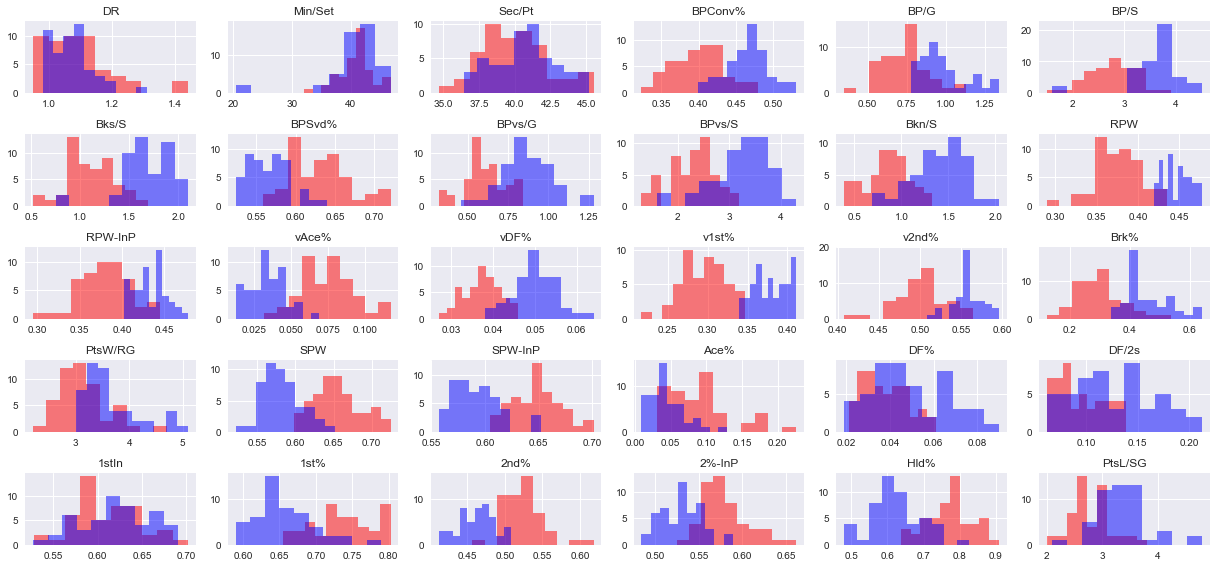

In [52]:
i = 1
plt.figure(figsize=(17,8))
for c in mt_df.columns.values[2:]:
    if c not in drop_cats:
        plt.subplot(n_cats/6, n_cats/5, i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        i += 1
plt.tight_layout()

From my naive perspective, it seems like there are three important aspects of player performance: serves, returns, and doing both in high pressure situations (i.e. break points). A break point happens when the receiving player is ahead by 1-3 points and only needs to "break" the serve of his/her opponent to win. I grouped the metrics into these three categories and plotted each category together.

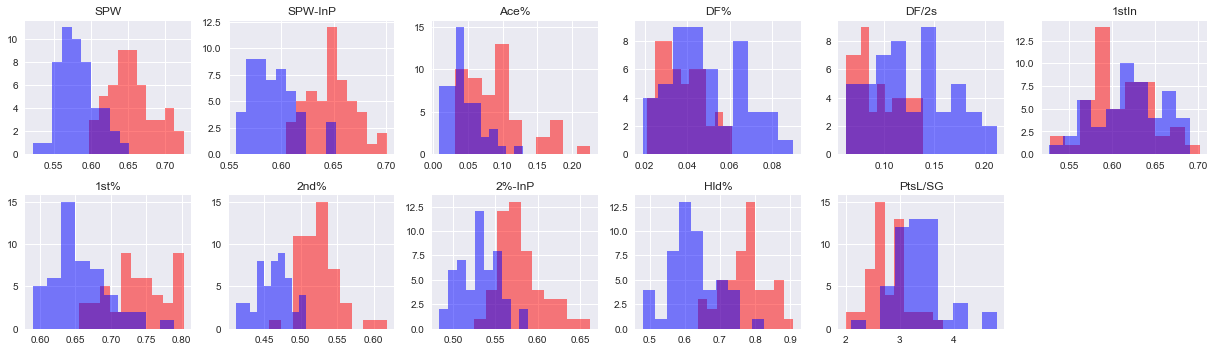

In [53]:
#service
service = ['SPW','SPW-InP','Ace%','DF%','DF/2s','1stIn','1st%','2%-InP','2nd%','Hld%','PtsL/SG']
ret = ['RPW','RPW-InP','vAce%','vDF%','v1st%','v2nd%','PtsW/RG','Bkn/S','Brk%']
breaks = ['BPvs/S','BPvs/G','BPConv%','BP/G','BP/S','BPSvd%']

i = 1
plt.figure(figsize=(17,5))
for c in mt_df.columns.values[2:]:
    if c in service:
        plt.subplot(2, 6, i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        i += 1
plt.tight_layout()

What becomes immediately clear is that men win more service points, have more aces, and win more service games than women. This makes a lot of sense considering that men likely have more powerful serves that are difficult to return. And it's also possible that women have focused more on improving their return game and men more on improving their service game. 

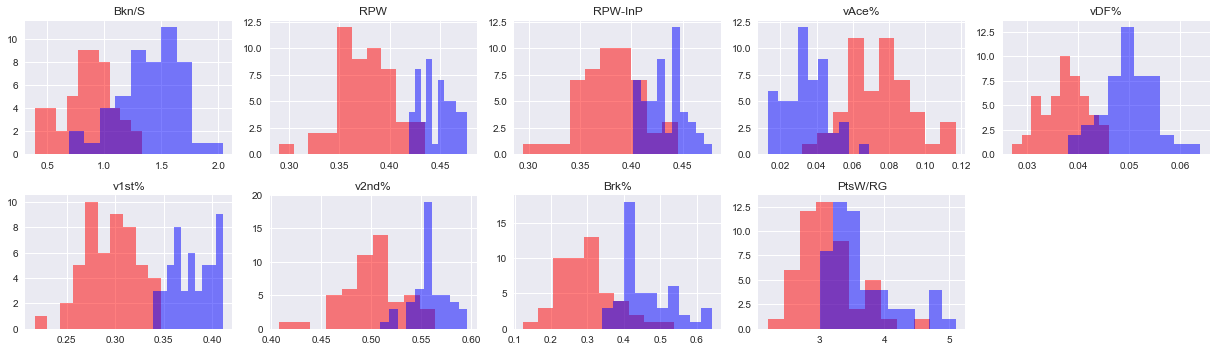

In [54]:
#returns
i = 1
plt.figure(figsize=(17,5))
for c in mt_df.columns.values[2:]:
    if c in ret:
        plt.subplot(2,5 , i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        i += 1
plt.tight_layout()



With returns, we observe the opposite situation: women win more return points, have fewer aces won against them, and win more return games. 

From what I can tell, men's tennis is more about serves and women's tennis is more about returns. 


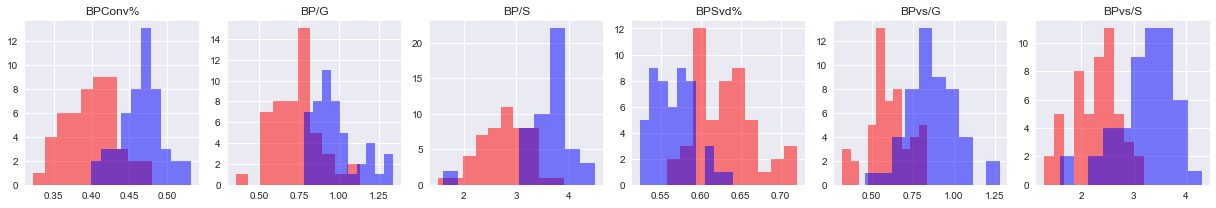

In [55]:
#breaks
i = 1
plt.figure(figsize=(17,3))
for c in mt_df.columns.values[2:]:
    if c in breaks:
        plt.subplot(1,6 , i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        i += 1
plt.tight_layout()

What does this look like when players are under pressure during break points? One would expect men to save more break points with serves, and women to convert more break points by successfully returning serves. Indeed, this is the case.

Out of curiousity, does the pressure of a break point benefit or harm a player's performance? I compared the average break point conversion rate to the percentage of return points won and the average break point saved rate to the percentage service points won.

In [63]:
print('Women\'s:')
print('BPConv% - RPW: ' + str(wt_df['BPConv%'].mean()-wt_df['RPW'].mean()))
print('BPSvd% - SPW: ' + str(wt_df['BPSvd%'].mean()-wt_df['SPW'].mean()))

print('Men\'s:')
print('BPConv% - RPW: ' + str(mt_df['BPConv%'].mean()-mt_df['RPW'].mean()))
print('BPSvd% - SPW: ' + str(mt_df['BPSvd%'].mean()-mt_df['SPW'].mean()))

Women's:
BPConv% - RPW: 0.01886
BPSvd% - SPW: -0.01598
Men's:
BPConv% - RPW: 0.02518
BPSvd% - SPW: -0.0235


It seems like, in general, break points benefit the performance of the return player and hurt the performance of the server. I could also look at these values for different players rather than group averages.

I then pooled all the data together into one data frame and looked at correlations among different features.

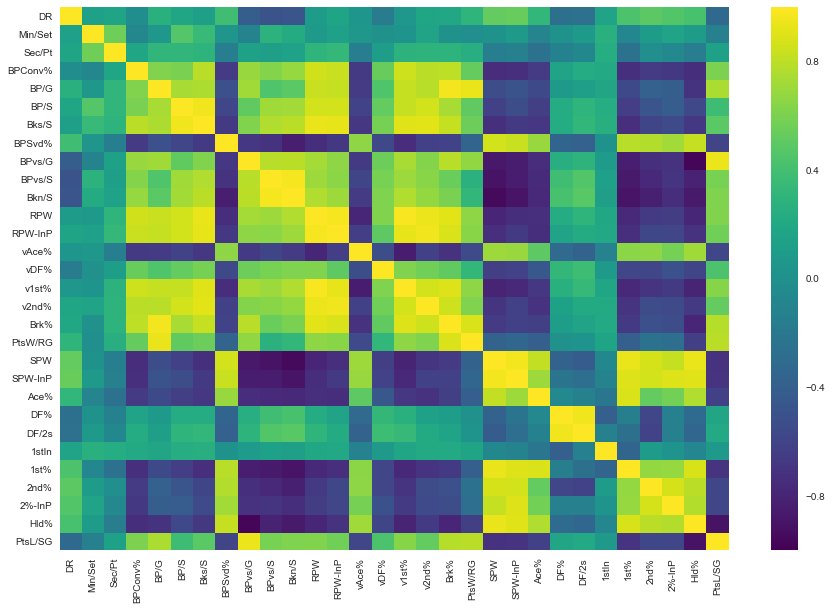

In [93]:
all_df = pd.concat([mt_df,wt_df],ignore_index=True)
rank = all_df['Rk']
gender = all_df['Gender']
all_df = all_df.drop(drop_cats,axis=1)
#get names
names = all_df['Player']
all_df = all_df.drop('Player',axis=1)
names = [n.replace('\xca',' ') for n in names]
         

plt.figure(figsize=(15,10))
corr = all_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap='viridis')

Many of these features are correlated with each other, which suggests that the dimensionality of this data is much lower than the number of features. I'll use PCA to reduce the dimensionality of the data and then examine the features encoded in the resulting principal components. PCA is a technique for dimensionality reduction that assumes that the data points are linear combinations of the features. 

Percentage of variance explained by the first 6 PCs: 0.911185


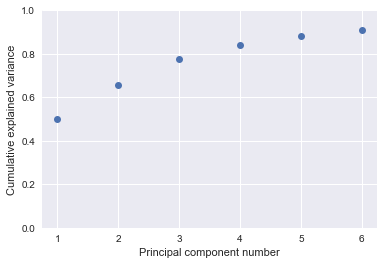

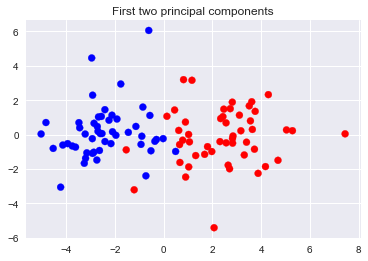

In [112]:
#normalize
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
X = RobustScaler().fit_transform(all_df.values)

#PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

plt.plot(range(1,len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_),'o')
plt.ylim([0,1])
plt.xlabel('Principal component number')
plt.ylabel('Cumulative explained variance')
print('Percentage of variance explained by the first %d PCs: %f' % (len(pca.explained_variance_ratio_),sum(pca.explained_variance_ratio_)))


plt.figure()
plt.title('First two principal components')
plt.scatter(X_pca[:,0],X_pca[:,1],c=gender,cmap='bwr')


So greater than 90% of the variability can be explained with the first 6 PCs (cf. 30 original features). I plotted the data using the first two principal components above (red = men, blue = women). Even with two components, the data are clearly segregated by gender. I know from looking at the data that these differences are mostly to do with serves vs. returns. Do the principal components, which can be thought of as "meta-features" that reflect combinations of features, tell me anything new about the structure of the data?

One way to get at this question is to ask which original features are correlated with the PCs. This is done by looking at the loadings and dividing by the standard deviations of the features. The loadings, $L_i$, are equal to:

$ L_i = e_i \sqrt{\lambda_i} $

where the $e_i$s are the eigenvectors and the $\lambda_i$s are their corresponding eigenvalues. 

In [113]:
cc = np.multiply(pca.components_,np.transpose(np.sqrt(np.matlib.repmat(pca.explained_variance_,np.shape(pca.components_)[1],1))))
feat_std = np.matlib.repmat(np.std(X,axis=0),np.shape(pca.components_)[0],1)
cc = np.divide(cc,feat_std)


def plot_corrs(corrs,data):
    for comp in range(0,np.shape(corrs)[0]):
        plt.subplot(2,3 , comp+1)
        feats = [(e,f) for e,f in sorted(zip(corrs[comp],data.columns.values),reverse=True)]
        loadings = zip(*feats)[0]
        names =  zip(*feats)[1]
        plt.bar(range(0,30),loadings)
        plt.title('PC' + str(comp+1))
        plt.xticks(range(0,30),names, rotation='vertical')
        plt.ylim((-1,1))
        plt.plot([0, 30], [.5, .5], color='k', linestyle='--', linewidth=1)
        plt.plot([0, 30], [-.5, -.5], color='k', linestyle='--', linewidth=1)


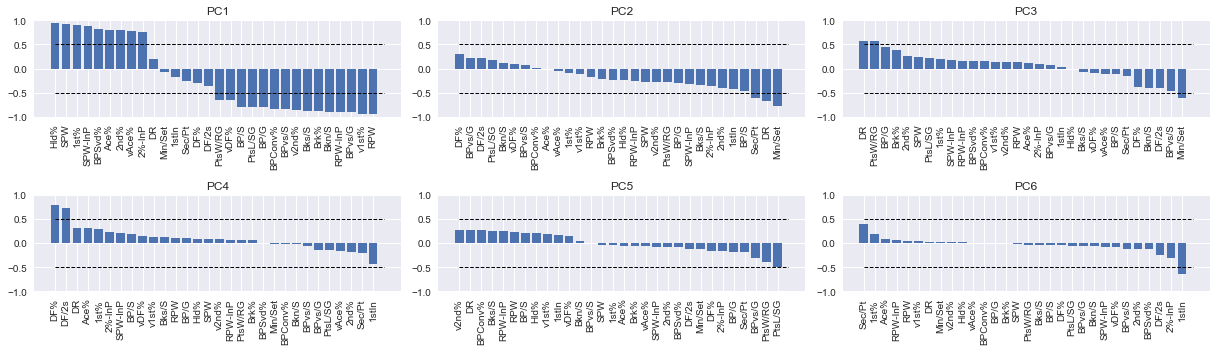

In [114]:
plt.figure(figsize=(17,5))
plot_corrs(cc,all_df)
plt.tight_layout()

The y-axis is Pearson's correlation coefficient. The first PC can roughly be described as serve and return data combined. The second PC contains information about the duration of sets/points and DR. Most of these components are actually difficult to describe and interpret. This doesn't give me much more information than I already had about the structure in the data. 

Since I don't have that many features to begin with, dimensionality reduction is not absolutely necessary and is only useful for visualization. I next used t-SNE to get a sense of the underlying structure of the data. T-SNE is a nonlinear dimensionality reduction technique, so it may give a better visualization of the structure. 

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.476568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.248989
[t-SNE] Error after 1000 iterations: 0.440603


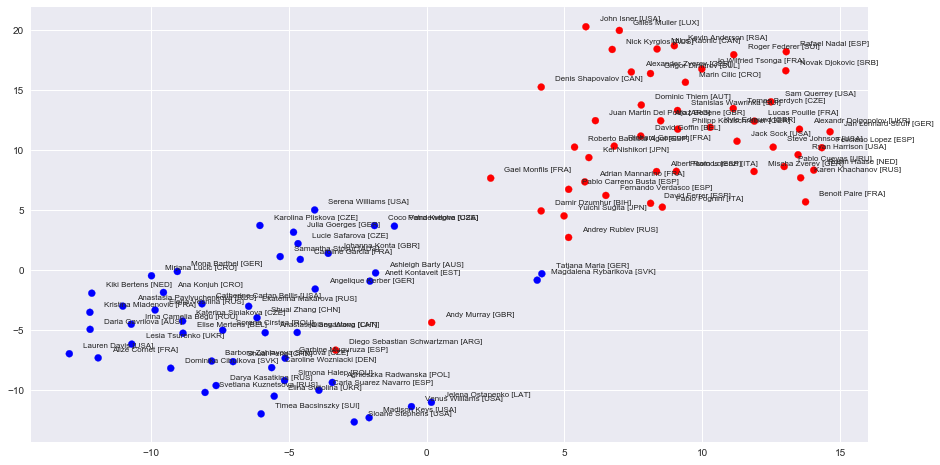

In [115]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
X_embedded = TSNE(n_components=2,perplexity=15,verbose=1,early_exaggeration=12).fit_transform(X)

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(X_embedded[:,0],X_embedded[:,1],c=gender,cmap='bwr')

for i, txt in enumerate(names):
    ax.annotate(txt, (X_embedded[i,0]+.5,X_embedded[i,1]+.5),fontsize=8)


Interestingly, there are two clusters in the t-SNE plot. With the exception of a few players, these clusters reflect gender. 

I next tried some unsupervised learning in the form of clustering on the data set. I chose affinity propagation because I didn't know the number of clusters present (although I had a good guess). The complexity of affinity propagation is $O(N^{2})$, but my data set is small. I used the labels from this clustering to color the t-SNE plot.

Number of clusters found: 2


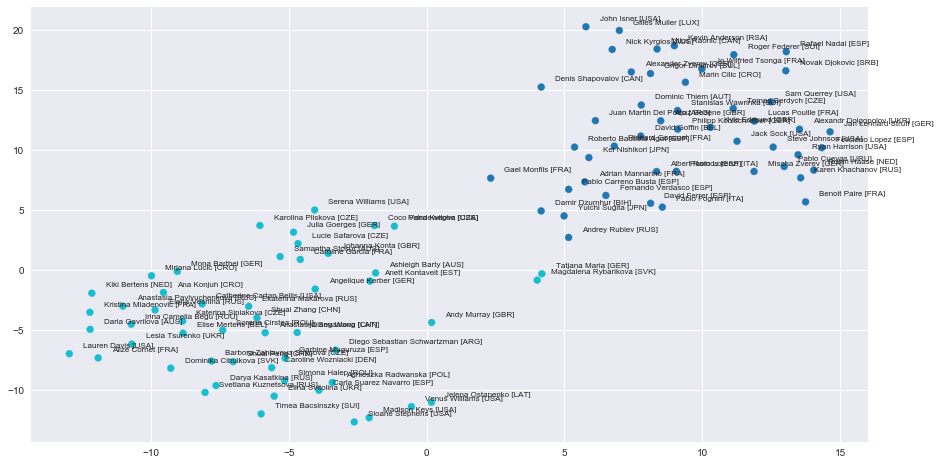

In [124]:
#cluster
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-200).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
print ('Number of clusters found: ' + str(n_clusters_))

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(X_embedded[:,0],X_embedded[:,1],c=labels,cmap='tab10')

for i, txt in enumerate(names):
    ax.annotate(txt, (X_embedded[i,0]+.5,X_embedded[i,1]+.5),fontsize=8)

This clustering aligns well with the clusters visually apparent in the t-SNE plot and is only slightly different than the gender identities.

So I've established that there are clear differences between male and female tennis players, and there appear to be at least two "types" (clusters) of tennis players that roughly, but not exactly, correspond to gender. What are the features that define these groups? I used mutual information to find features that give the most information about gender and features that give the most information about player type.  

(0, 1)

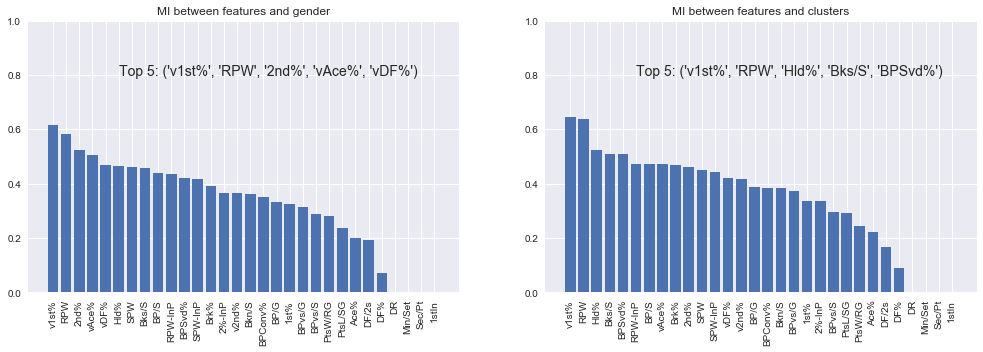

In [141]:
#try mutual information/entropy about gender
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(all_df.values,gender,discrete_features=False)
feats = []
plt.figure(figsize = (17,5))
ax = plt.subplot(1,2,1)
for i,m in enumerate(mi):
    feats.append((all_df.columns.values[i],m))
feats.sort(key=lambda x: x[1], reverse=True)
labs = zip(*feats)[0]
mis = zip(*feats)[1]
plt.bar(range(0,30),mis)
plt.xticks(range(0,30),labs, rotation='vertical')
ax.annotate('Top 5: ' + str(labs[0:5]), (5,0.8),fontsize=14)
plt.ylim((0,1))
plt.title('MI between features and gender')



ax = plt.subplot(1,2,2)
#try mutual information/entropy about categories
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(all_df.values,labels,discrete_features=False)
feats = []
for i,m in enumerate(mi):
    feats.append((all_df.columns.values[i],m))
feats.sort(key=lambda x: x[1], reverse=True)
labs = zip(*feats)[0]
mis = zip(*feats)[1]
plt.bar(range(0,30),mis)
plt.title('MI between features and clusters')
ax.annotate('Top 5: ' + str(labs[0:5]), (5,0.8),fontsize=14)
plt.xticks(range(0,30),labs, rotation='vertical')
plt.ylim((0,1))



The top 5 features for both groupings are very similar: Percentage of first serve return points won (v1st%) and percentage of return points won (RPW) give the most information for both gender and the clustering. 

At this point, I wasn't really satisfied with these techniques in terms of interpretability. Theoretically they should be helpful for interpreting the data, but they haven't clearly shown me the patterns that I was able to detect just by looking at the data. In this particular case I'm cheating since I already kind of know the answer to my question, but I wanted to use this project as practice for when I work with data sets that are too large to be examined visually. The importance of interpretability varies depending on one's goals, but in my case I really wanted an algorithm to give me the "take-home" message.

That's when I came across self-organizing maps, or SOMs. SOMs are artificial neural networks composed of a (usually) two-dimensional grid of neurons that learn by competitive learning. They are used in unsupervised learning to cluster and visualize high-dimensional data while preserving the overall topology of the data. Each neuron is connected to every input feature with a weight vector with length equal to the number of input features. The weight vectors are initialized, a random data point is compared to each of the weight vectors and is matched to the neuron with a weight vector most closely matching that data point. This neuron is known  as the best-matching unit, or BMU. Weights for neurons within a certain radius of the BMU in the grid are updated, with changes proportional to their distance from the BMU. This process is repeated for a specified number of iterations. Once complete, the grid of neurons has learned some structure from the data. One can see a clustering of the data on the grid and can gain insight into the clustering via the weight vectors. 

I decided to use this on the tennis data to a) cluster the data points and b) interpret the clusters. I found an implementation here: http://blog.yhat.com/posts/self-organizing-maps-2.html. 

In [149]:
#Implement SOM
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))
                  
  
                  
dim = 2
map_dims = np.array([6,6])
n_iterations = 10000
init_learning_rate = 0.01

# establish size variables based on data
m = X.shape[1]
n = X.shape[0]

# weight matrix (i.e. the SOM) needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((map_dims[0], map_dims[1], m))

# initial neighbourhood radius
init_radius = max(map_dims[0], map_dims[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

for i in range(n_iterations):
    # select a training example at random
    t = X[np.random.randint(0, n),:].reshape(np.array([m, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)



    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 30)
                

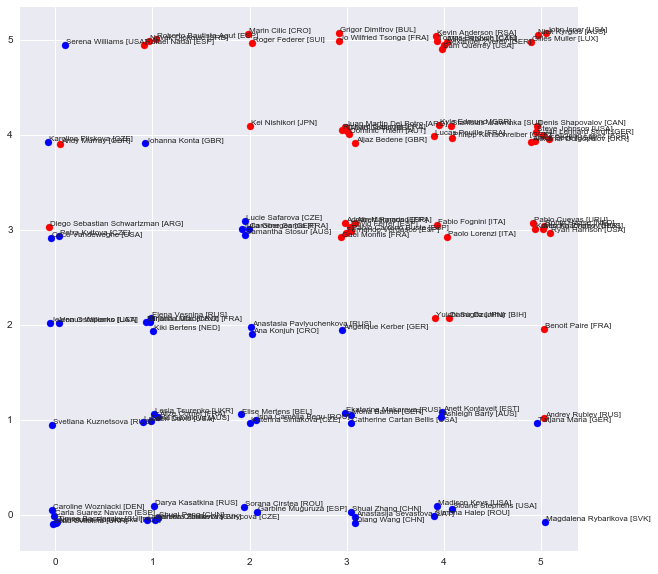

In [151]:
#visualize clusters
assignments = []
fig, ax = plt.subplots(figsize=(10,10))
colors = ['b','r']
for i in range(X.shape[0]):
    t = X[i,:].reshape(np.array([m, 1]))
    bmu, bmu_idx = find_bmu(t, net, m)
    assignments.append(bmu_idx)
    xval =bmu_idx[0]+(np.random.rand()-.5)/5
    yval = bmu_idx[1]+(np.random.rand()-.5)/5
    ax.scatter(xval,yval,c=colors[gender[i]],cmap='bwr')

    ax.annotate(names[i], (xval+.01,yval+.01),fontsize=8)

The clustering is very similar to what I've seen before. Now I can look at the weight vectors that contribute to this clustering. The weights for each feature are plotted as heatmaps below. 

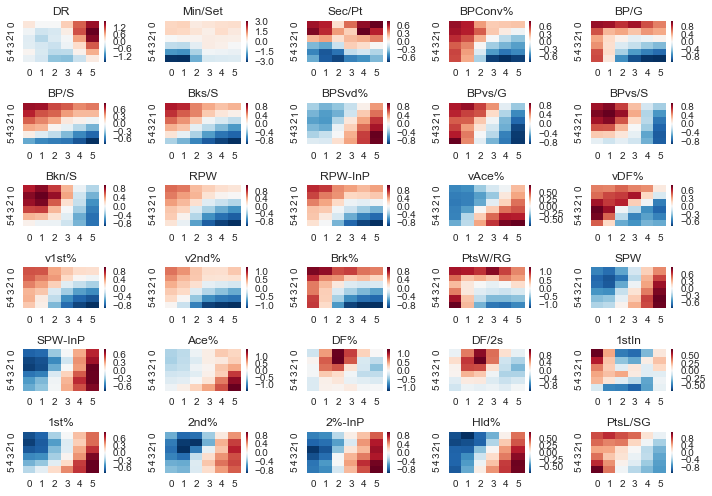

In [155]:
feature_maps = np.ones((net.shape[2],net.shape[0]*net.shape[1]))
plt.figure(figsize = (10,7))
for i in range(net.shape[2]):
    plt.subplot(6,5,i+1)
    sns.heatmap(net[:,:,i])
    feature_maps[i,:] = net[:,:,i].flatten()
    plt.title(all_df.columns.values[i])
plt.tight_layout()

Now I'll perform a clustering analysis on the heatmaps to see which features cluster together. I'll use the DBSCAN algorithm because I don't need to specify the number of clusters in advance, and it doesn't force every point to belong to a cluster (i.e. it indicates points that are "noisy")

In [178]:
#normalize
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
X_F = RobustScaler().fit_transform(feature_maps)
#DBSCAN
db = DBSCAN(eps=2.0, min_samples=5).fit_predict(X_F)


print('Cluster 1: ')
print(all_df.columns.values[np.where(db == 0)])

print('Cluster 2: ')
print(all_df.columns.values[np.where(db == 1)])

print('Noisy Features: ')
print(all_df.columns.values[np.where(db == -1)])

Cluster 1: 
['BPConv%' 'BP/S' 'Bks/S' 'RPW' 'RPW-InP' 'v1st%' 'v2nd%' 'Brk%']
Cluster 2: 
['BPSvd%' 'vAce%' 'SPW' 'SPW-InP' '1st%' '2nd%' '2%-InP' 'Hld%']
Noisy Features: 
['DR' 'Min/Set' 'Sec/Pt' 'BP/G' 'BPvs/G' 'BPvs/S' 'Bkn/S' 'vDF%' 'PtsW/RG'
 'Ace%' 'DF%' 'DF/2s' '1stIn' 'PtsL/SG']


Cluster 1 contains features that are higher in women, and higher numbers for these features indicate success at returns. Cluster 2 contains features that are higher in men, and higher numbers for these features indicate success at serving except for vAce% (Ace percentage against), which likely means that the men are facing more difficult serves from their opponents.

I consider this a success! I was able to summarize the patterns in the data in an easy-to-understand way using an automated technique. In general, men's and women's tennis is very different, but there were a few players that deviated substantially from their gender's distribution. I next sought to understand these deviations. 

Andy Murray and Diego Sebastián Schwartzman consistently cluster with the women. Based on information gleaned from gender differences, I hypothesize that both of these men have weak serve statistics but strong return statistics.

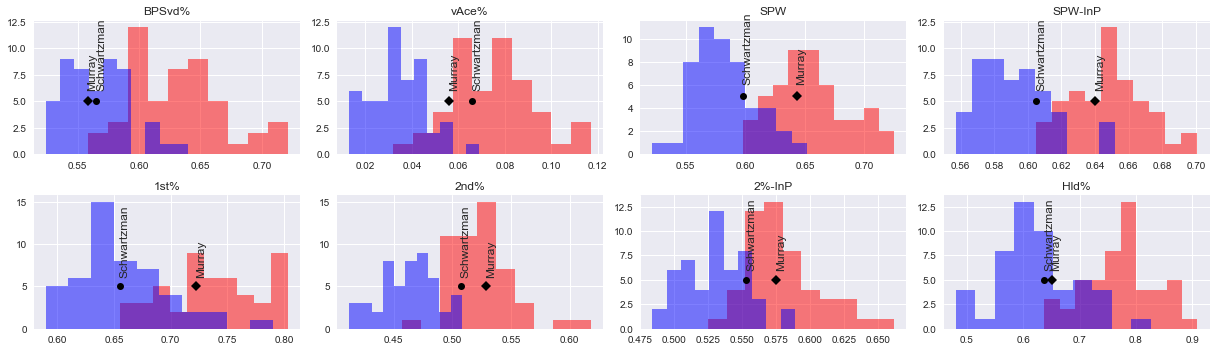

In [235]:
#features higher in men
clus_2 = ['BPSvd%' ,'vAce%' ,'SPW' ,'SPW-InP', '1st%', '2nd%', '2%-InP', 'Hld%']
i = 1
plt.figure(figsize=(17,5))
for c in mt_df.columns.values[2:]:
    if c in clus_2:
        ax = plt.subplot(2, 4, i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        plt.plot(mt_df[mt_df['Rk']==3][c].values[0],5,'kD')
        plt.plot(mt_df[mt_df['Rk']==25][c].values[0],5,'ko')
        ax.annotate('Murray', (mt_df[mt_df['Rk']==3][c].values[0],5+1),fontsize=12,rotation=90,va='bottom')
        ax.annotate('Schwartzman', (mt_df[mt_df['Rk']==25][c].values[0],5+1),fontsize=12,rotation=90,va='bottom')
        i += 1
plt.tight_layout()

Both players are average or below average for men on serve performance metrics.

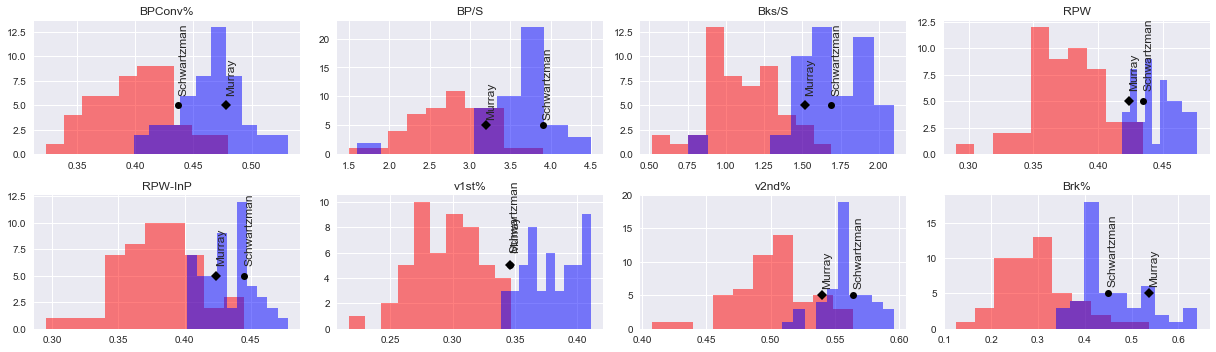

In [236]:
#features higher in women
clus_1 = ['BPConv%' ,'BP/S' ,'Bks/S' ,'RPW', 'RPW-InP', 'v1st%' ,'v2nd%' ,'Brk%']
i = 1
plt.figure(figsize=(17,5))
for c in mt_df.columns.values[2:]:
    if c in clus_1:
        ax = plt.subplot(2, 4, i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        plt.plot(mt_df[mt_df['Rk']==3][c].values[0],5,'kD')
        plt.plot(mt_df[mt_df['Rk']==25][c].values[0],5,'ko')
        ax.annotate('Murray', (mt_df[mt_df['Rk']==3][c].values[0],5+1),fontsize=12,rotation=90,va='bottom')
        ax.annotate('Schwartzman', (mt_df[mt_df['Rk']==25][c].values[0],5+1),fontsize=12,rotation=90,va='bottom')
        i += 1
plt.tight_layout()




On returns, Murray and Schwartzmen are better than most men. Perhaps they are aware of their weak serve performance and work hard on their return game.

I noted earlier than Serena Williams has the highest dominance ratio of all women. This likely has to do with her serve. 

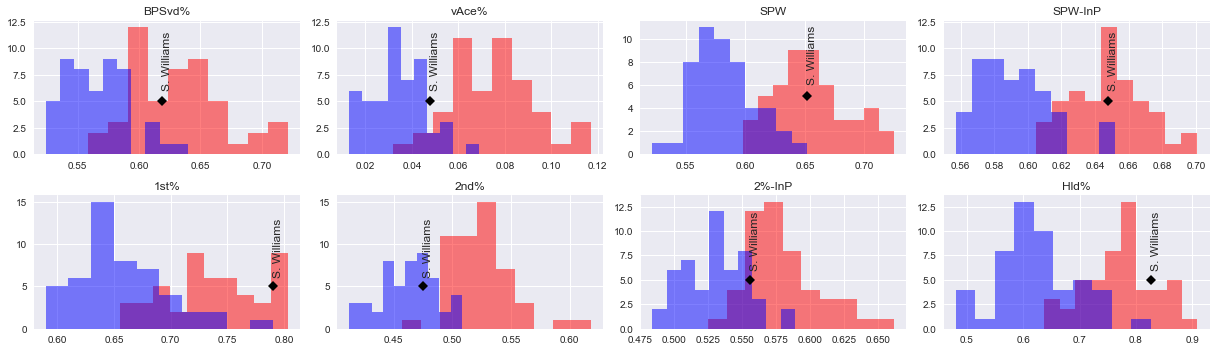

In [238]:
#features higher in men
i = 1
plt.figure(figsize=(17,5))
for c in mt_df.columns.values[2:]:
    if c in clus_2:
        ax = plt.subplot(2, 4, i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        plt.plot(wt_df[wt_df['Rk']==21][c].values[0],5,'kD')

        ax.annotate('S. Williams', (wt_df[wt_df['Rk']==21][c].values[0],5+1),fontsize=12,rotation=90,va='bottom')
       
        i += 1
plt.tight_layout()

Serena is substantially above the average woman for some of these serve metrics.

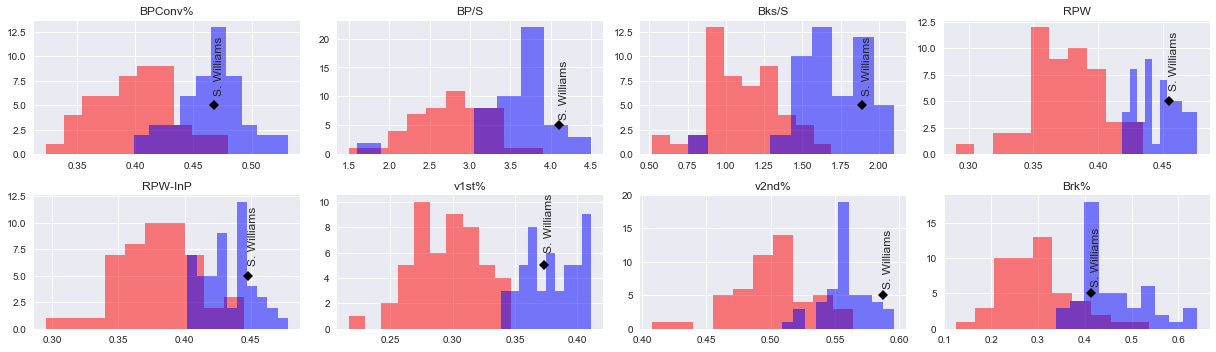

In [239]:
#features higher in men
i = 1
plt.figure(figsize=(17,5))
for c in mt_df.columns.values[2:]:
    if c in clus_1:
        ax = plt.subplot(2, 4, i)
        plt.title(c)
        plt.hist(mt_df[c].values,bins=10,color='r',alpha=.5) 
        plt.hist(wt_df[c].values,bins=10,color='b',alpha=.5)
        plt.plot(wt_df[wt_df['Rk']==21][c].values[0],5,'kD')

        ax.annotate('S. Williams', (wt_df[wt_df['Rk']==21][c].values[0],5+1),fontsize=12,rotation=90,va='bottom')
       
        i += 1
plt.tight_layout()

And her returns are average or above average for women.

## Conclusions

I was able to learn a lot about tennis from this data with very little background in the game. Women's tennis emphasizes a better return game, while men's tennis is dominated by strong servers. Break points favor the receiving player in terms of performance. A few players break the norm. For men, these players are likely making up for a weak serve. 

SOMs are a cool way to perform unsupervised clustering with an interpretable 